In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser.devices import AnalogDevice, MockDevice, DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform, RampWaveform, BlackmanWaveform, CompositeWaveform
from pulser_simulation import QutipEmulator, SimConfig
import networkx as nx
from scipy.spatial.distance import pdist, squareform
import matplotlib as mpl
from matplotlib.patches import Rectangle

# 3. Quantum simulation: State preparation of Rydberg crystals

In this section, we design a pulse to prepare the ground state of a chain of atoms subject to different blockade radius. 

The blockade radius $R_b$ is tuned by $\Omega_{max}$ following $R_b = (C_6/\Omega_{max})^{1/6}$. 

We also want to tune the detuning applied on the atoms - large final detuning $\delta_f$ forces the occupation of excited Rydberg states (while subject to the blockade phenomena), while small to non-existent detuning will leave the state in the $|000...0\rangle$ state. In general, the phase diagram we can expect is given by:

<center><img src="../images/phasediagram.png" width="1200"/></center>

Our first goal is to prepare the $Z_2, Z_3, ...$ states on a linear chain. These states are on the far right of the above graph. 

Later on in the section, we will tune the final detuning $\delta_T = \alpha \delta_{max}$ of the pulse to move on the red dotted lines and probe the quantum phase transition from the disordered to the ordered $Z_N$ state, thus preparing ground states of the quantum hamilonian.

$$ \frac{\mathcal{H}}{\hbar} = \sum_i ( \Omega_{max} \sigma_i^x - \alpha \delta_{max} n_i  + \sum_{j<i} \frac{C_6}{r_{ij}^6} n_i n_j )$$



We first start by creating a register for a 1D chain with open boundary conditions. 

We can tune the atomic separation $a$ and the blockade radius $R_b$ so as to engineer different $Z_N$ phases. In order to realize blockaded $Z_N$ phases, we tune the parameter `periodicity` which is really $N+1$. For best results, make sure that the $Z_N$ pattern you are trying to realize is commensurate with the size of the chain. For example, for a $Z_3$ phase, you could have $N_{atoms} = 4,7,10,...$. You can check that the parameters you've put are consistent by checking that the N of $Z_N$ crystal is $N = \lceil R_b/a \rceil + 1$.

Blockade Radius is: 6.119999999999999µm.
Interatomic distance is: 6.0µm.
Omega max is: 103.15812889129755 rad/us.
Ratio R_b/a is: 1.0199999999999998µm. 


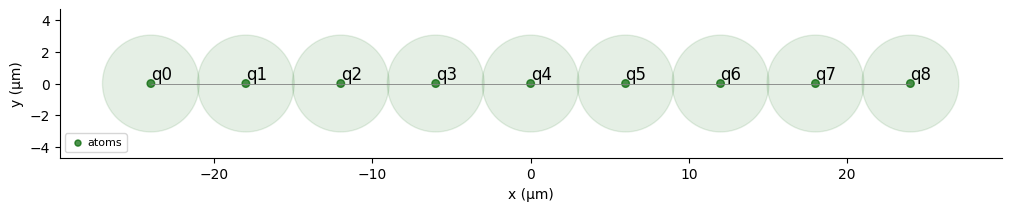

In [9]:
device_used = MockDevice #a simple virtual device
#distance between atoms
a = 6.0

#number of atoms in chain
N_atoms = 9 
#the blockade radius has to cover a certain number of sites
R_blockade= 1.02*a #we want to set the blockade radius at this

#find the corresponding Omega_max for this R_blockade 
#note that we restrict Omega_max to not be larger than 2*2*np.pi
# that is the max allowed Rabi amplitude on real QPUs 
Omega_max = max(device_used.rabi_from_blockade(R_blockade), 2 * 2 * np.pi) #we may be limited by the max Omega achievable on the device
#rederive the final R_blockade
R_blockade = device_used.rydberg_blockade_radius(Omega_max)

#define a Register of N_atoms in a line
reg = Register.rectangle(1, N_atoms, spacing=a, prefix="q")
print(f"Blockade Radius is: {R_blockade}µm.")
print(f"Interatomic distance is: {a}µm.")
print(f"Omega max is: {Omega_max} rad/us.")
print(f"Ratio R_b/a is: {R_blockade/a}µm. ")

#draw the register
reg.draw(blockade_radius=R_blockade, draw_half_radius=True)


Then, we create a quantum annealing pulse to prepare the ground state. 

Here, we want to take the system from the the known state $|0000...\rangle$ at $t=0$ to the ground state of the simulated hamiltonian at $t=T$. To do so, we continuously alter the Hamiltonian's parameters in time, and create a path that is inspired by the quantum adiabatic algorithm.

The pulse design needs to have
- $t=0$:    $\delta (t=0) = \delta_0 < 0$, $\Omega (t=0) = 0$ - initial state is $|0000...\rangle$;
- $t=T/2$:     $\delta (t=T/2) = 0$, $\Omega (t=T/2) = \Omega_{max}$ - we apply $\Omega_{max}$ to enforce the Rydberg blockade constraints;
- $t=T$:   $\delta (t=T) = \delta_f > 0$, $\Omega (t=T) = 0$ - final state maximizes the number of Rydberg excitations.

We set $\delta_0 = \delta_f = 2*\Omega_{max}$, and design a heuristic rise - sweep - fall pulse, as you can see below. The duration of each section can be adjusted. Once you've completed the section, we recommend you play with those to get a sense of what could be the optimal parameters to design your analog state preparation routine with the highest fidelity. In general, you can also implement more general parametrized pulses and optimize the parameters as you would in a QAOA algorithm. 

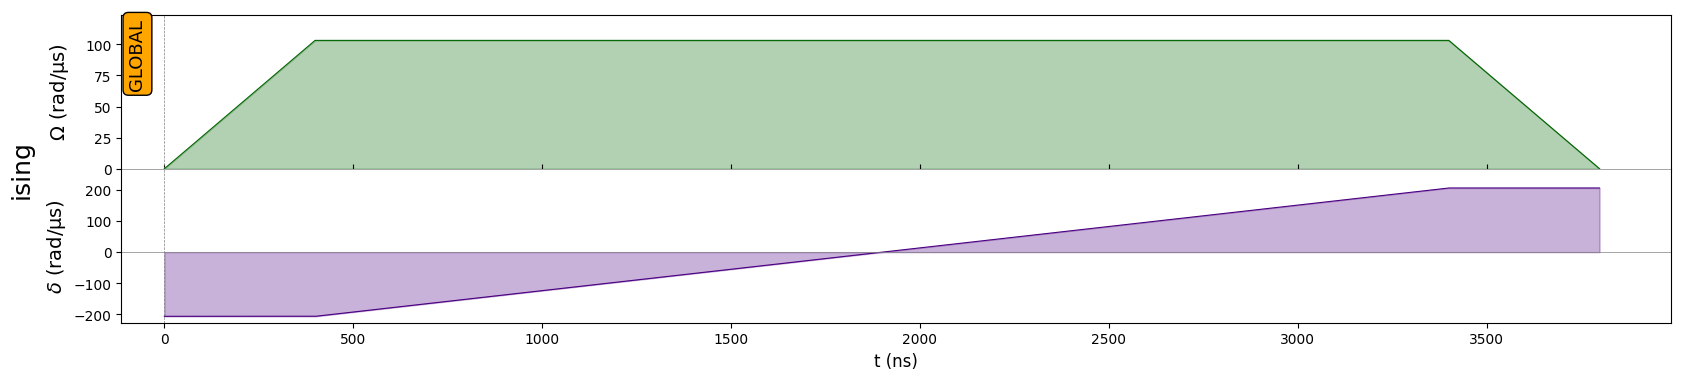

In [10]:
#detuning values
delta_0 = -2.0 * Omega_max
delta_f = 2.0 * Omega_max
#rise, sweep, fall times: these times are in ns
t_rise = 400 
t_sweep = 3000
t_fall = 400

#create the pulse shapes
rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
sweep = Pulse.ConstantAmplitude(
    Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)

#create the sequence
seq = Sequence(reg, MockDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(rise, "ising", "no-delay")
seq.add(sweep, "ising", "no-delay")
seq.add(fall, "ising", "no-delay")
seq.draw()

Next, we run an "experiment" using this pulse and register. This is done through the `QutipEmulator` object, which performs a statevector emulation. The final results is stored in the `results` object.

An example of a noiseless and noisy noise configuration is shown, so that you may try the effects of reasonable noise on the simulation. **Careful!** Running a noisy simulation can take quite longer!

In [11]:
noise_config = {'noiseless': None, 
                'noisy': SimConfig(
    noise=("SPAM", "dephasing", "doppler"),
    epsilon=0.01, #false positive
    epsilon_prime=0.05, #false negatives
    temperature=1000,
    dephasing_rate=0.03,
    runs=50,) 
}

simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=1, #change the sampling of the wavefunction
                                    config=noise_config['noiseless'])
simul.show_config()
results = simul.run(progress_bar=True)


Options:
----------
Number of runs:        15
Samples per run:       5
10.0%. Run time:   0.16s. Est. time left: 00:00:00:01
20.0%. Run time:   0.33s. Est. time left: 00:00:00:01
30.0%. Run time:   0.50s. Est. time left: 00:00:00:01
40.0%. Run time:   0.64s. Est. time left: 00:00:00:00
50.0%. Run time:   0.78s. Est. time left: 00:00:00:00
60.0%. Run time:   0.90s. Est. time left: 00:00:00:00
70.0%. Run time:   1.04s. Est. time left: 00:00:00:00
80.0%. Run time:   1.19s. Est. time left: 00:00:00:00
90.0%. Run time:   1.37s. Est. time left: 00:00:00:00
100.0%. Run time:   1.60s. Est. time left: 00:00:00:00
Total run time:   1.60s


Select a number of samples (a.k.a shots), and sample the results of the Qutip backend simulation. This will return a Counter of bitstrings and how many times they were obtained. In these bitstrings, a `0` corresponds to an atom in the ground state, while a `1` is an atom in the Rydberg state - this is the $n_i$ Rydberg occupation basis.

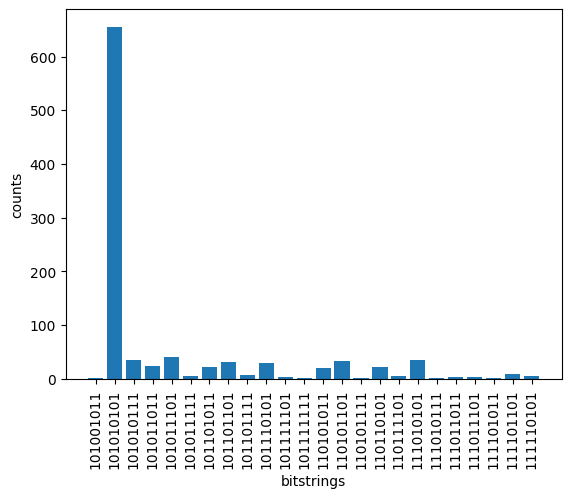

In [12]:
N_samples = 1000
count_dict = results.sample_final_state(N_samples=N_samples)
#we filter the counts to show only states seen more than threshold of the time.
threshold = 0.0*N_samples #no threshold
# threshold = 0.05*N_samples #5% threshold
most_freq = {k: v for k, v in count_dict.items() if v > threshold} 
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel('counts')
plt.xlabel('bitstrings')
plt.show()

We then plot the average Rydberg occupation of each site $\langle n_i \rangle$, which is obtained by counting the contribution of each bitstring. This is collected in `avg_occupation`

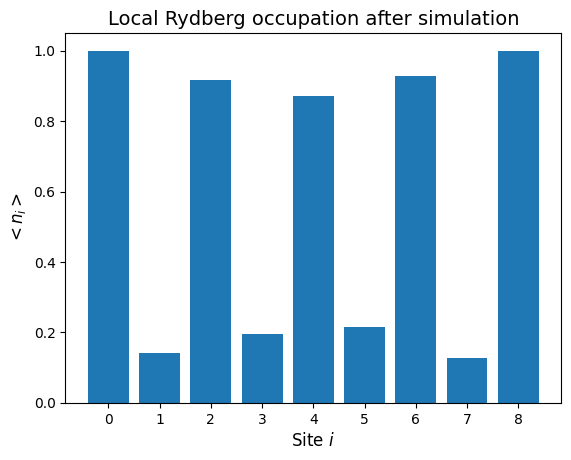

In [13]:
avg_occupation = np.zeros(N_atoms)
for key_str, count in count_dict.items():
    for i in range(N_atoms):
        if key_str[i] == '1':
            avg_occupation[i] += count
values = np.array(avg_occupation/N_samples)
plt.bar(x = range(N_atoms), height=values)
plt.xticks(
    range(values.shape[0]), ["{}".format(i) for i in range(N_atoms)]
)
plt.title(r"Local Rydberg occupation after simulation", fontsize=14)
plt.xlabel(r"Site $i$", fontsize=12)
plt.ylabel(r"$<n_i>$", fontsize=12)
# plt.ylim([-ylim, ylim])
plt.show()

We can characterize how good of a job we did in preparing the $Z_2$ state by computing the **staggered order parameter** $M_2$ on the bitstrings obtained. This is given by:

$$M_2(\vec{n}) = \sum_i (-1)^i (2*n_i - 1)$$

We then average over many bistring configurations:

$$m_2 = \langle M_2(\vec{n}) \rangle = \sum_{\{ \vec{n} \}} M_2(\vec{n})$$



In [14]:
Z_2_occupation = np.zeros(N_atoms)
for key_str, count in count_dict.items():
    for i in range(N_atoms):
        if key_str[i] == '1':
            Z_2_occupation[i] += (-1)**i * count 
        else:
            Z_2_occupation[i] += -(-1)**i * count
Z_2_occupation = np.sum(Z_2_occupation/N_samples)/N_atoms
print('m_2 = ', Z_2_occupation)

m_2 =  0.7855555555555556


## Excercise 3.1:

- Qu'arrive-t'il lorsque vous réduisez ou augmentez le temps passé à $\Omega = \Omega_{max}$? Et si c'était $1 \mu s$? Et si c'était $10 \mu s$?

## Exercise 3.2:

- Pour votre préparation d'état Z_2, quels devraient être les bitstrings de plus basse énergie pour une chaîne avec un nombre pair d'atomes? 
- Si vous faites une simulation de cela, est-ce que ça fonctionne avec votre intuition?
- Qu'en est-il pour une chaîne périodique?

## Exercise 3.3:

- Pouvez-vous adapter le code pour réaliser des chaînes où la bitstring de plus basse énergie est un autre état $Z_N$, comme $Z_3$ et $Z_4$?
- Est-ce plus difficile ou plus facile à réaliser ces états? Pourquoi?

# 4: Probing the quantum phase transition

In order to prepare this state, we had to go through a phase transition between a known state $|000...0\rangle$ and the ground state of the atomic chain, as was shown in the phase diagram. 

<center><img src="../images/phasediagram.png" width="1200"/></center>

>We can probe this phase transition by using the same register, but changing the parameters of the pulse. We will then create a function called `prepare_at_given_detuning` that takes a parameter `alpha` and corresponds to the pulse needed to simulate the Hamiltonian 

$$ \frac{\mathcal{H}}{\hbar} = \sum_i ( \Omega_{max} \sigma_i^x - \alpha \delta_{max} n_i  + \sum_{j<i} \frac{C_6}{r_{ij}^6} n_i n_j )$$

This new pulse is like our original pulse, but we tune the final detuning $\delta_T = \alpha \delta_{max}$. Tuning $\alpha$ is like moving on the red dashed line.

Note that this section works best for the $Z_2$ state.

In [15]:
a = 5.0
periodicity = 2 
N_atoms = 9 #number of atoms in chain
R_blockade= (periodicity - 1)*1.05*a
Omega_max = min(device_used.rabi_from_blockade(R_blockade), 2 * 2 * np.pi)
R_blockade = device_used.rydberg_blockade_radius(Omega_max)

reg = Register.rectangle(1, N_atoms, spacing=a, prefix="q")


def prepare_at_given_detuning(alpha, t_sweep):
    U = 2*Omega_max
    delta_0 = -1.0 * U
    delta_f = 1.0 * U
    #these times are in ns
    t_rise = 400
    t_fall = 400
    delta_f_alt = alpha*delta_f

    rise = Pulse.ConstantDetuning(
        RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
    )
    sweep_1 = Pulse.ConstantAmplitude(
        Omega_max, RampWaveform(t_sweep/2, delta_0, 0), 0.0
    )
    sweep_2 = Pulse.ConstantAmplitude(
        Omega_max, RampWaveform(t_sweep/2, 0, delta_f_alt), 0.0
    )
    seq = Sequence(reg, device_used)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(rise, "ising", "no-delay")
    seq.add(sweep_1, "ising", "no-delay")
    seq.add(sweep_2, "ising", "no-delay")
    fall = Pulse.ConstantDetuning(
        RampWaveform(t_fall, Omega_max, 0.0), delta_f_alt, 0.0
    )
    seq.add(fall, "ising", "no-delay")
    
    return seq

Show a given sequence for $\alpha = 0.5$

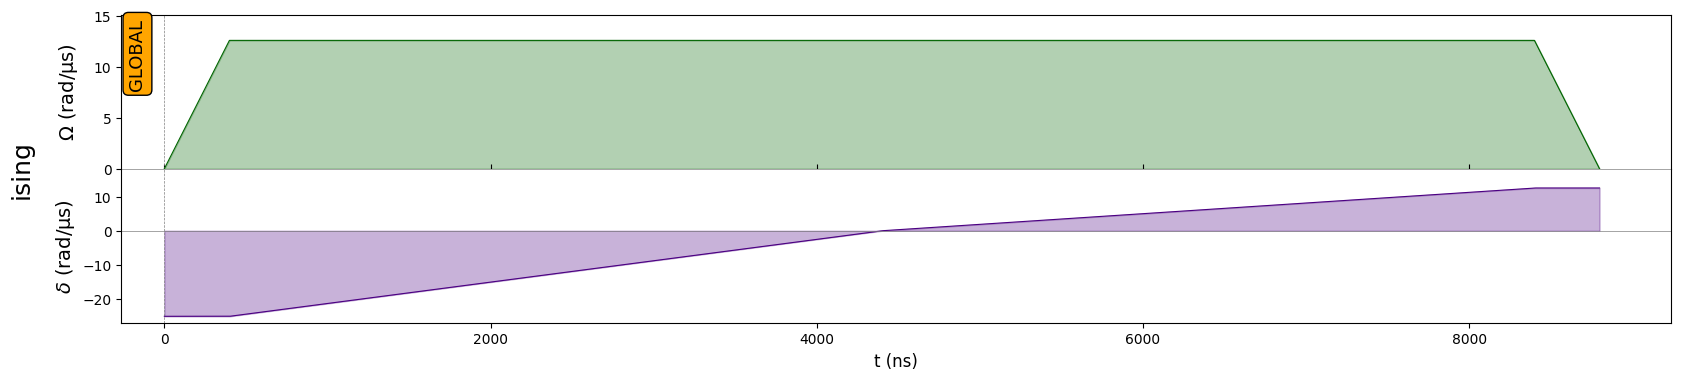

In [16]:
seq = prepare_at_given_detuning(alpha = 0.5, t_sweep=8000)
seq.draw()

Perform the emulation.

In [17]:
simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=1, #change the sampling of the wavefunction
                                    )
simul.show_config()
results = simul.run(progress_bar=True)


Options:
----------
Number of runs:        15
Samples per run:       5
10.0%. Run time:   0.72s. Est. time left: 00:00:00:06
20.0%. Run time:   1.63s. Est. time left: 00:00:00:06
30.0%. Run time:   2.68s. Est. time left: 00:00:00:06
40.0%. Run time:   4.21s. Est. time left: 00:00:00:06
50.0%. Run time:   5.78s. Est. time left: 00:00:00:05
60.0%. Run time:   7.35s. Est. time left: 00:00:00:04
70.0%. Run time:   8.85s. Est. time left: 00:00:00:03
80.0%. Run time:  10.43s. Est. time left: 00:00:00:02
90.0%. Run time:  11.86s. Est. time left: 00:00:00:01
100.0%. Run time:  13.39s. Est. time left: 00:00:00:00
Total run time:  13.39s


Show the bitstring distribution for this run.

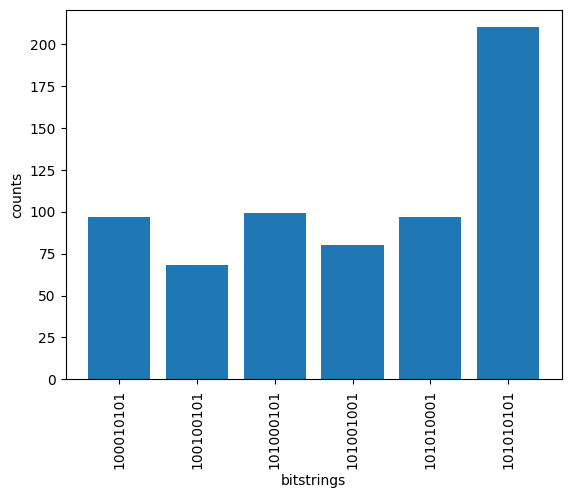

In [18]:
N_samples = 1000
count_dict = results.sample_final_state(N_samples=N_samples)
#we filter the counts to show only states seen more than threshold of the time.
# threshold = 0.0*N_samples #no threshold
threshold = 0.05*N_samples #5% threshold
most_freq = {k: v for k, v in count_dict.items() if v > threshold} 
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel('counts')
plt.xlabel('bitstrings')
plt.show()

Already, we see that we obtained a different distribution of bitstrings.

Again, we show the average Rydberg occupation per site. Note that, for $\alpha = 0.5$, the $Z_2$ pattern is not as clear - it has started to melt.

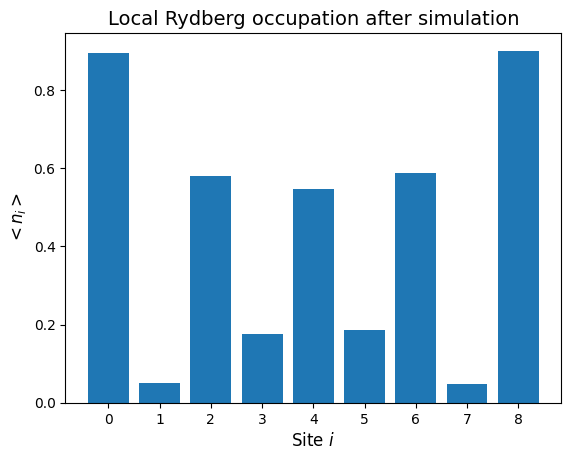

In [19]:
N_samples = 1000
count_dict = results.sample_final_state(N_samples=N_samples)
avg_occupation = np.zeros(N_atoms)
for key_str, count in count_dict.items():
    for i in range(N_atoms):
        if key_str[i] == '1':
            avg_occupation[i] += count
values = np.array(avg_occupation/N_samples)
plt.bar(x = range(N_atoms), height=values)
plt.xticks(
    range(values.shape[0]), ["{}".format(i) for i in range(N_atoms)]
)
plt.title(r"Local Rydberg occupation after simulation", fontsize=14)
plt.xlabel(r"Site $i$", fontsize=12)
plt.ylabel(r"$<n_i>$", fontsize=12)
# plt.ylim([-ylim, ylim])
plt.show()

We compare $m_2$ (as defined above) as we tune $\alpha$. In a perfect $Z_2$ crystal, we have $m_2 = 1$, while in a disordered state, it will tend to zero. This is called the order parameter. This cell can take up to 1 minute to run, depending on your computer.


In [20]:
alphas = np.linspace(0.0, 1.0, 15)
data = np.zeros(len(alphas))
for n in range(len(alphas)):
    seq = prepare_at_given_detuning(alpha = alphas[n], t_sweep=10_000)
    simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=0.5, #change the sampling of the wavefunction
                                    with_modulation=False, #modulate the signal like a real device
                                    )
    results = simul.run(progress_bar=False)
    N_samples = 1000
    count_dict = results.sample_final_state(N_samples=N_samples)
    Z_2_occupation = np.zeros(N_atoms)
    for key_str, count in count_dict.items():
        for i in range(N_atoms):
            if key_str[i] == '1':
                Z_2_occupation[i] += (-1)**i * count 
            else:
                Z_2_occupation[i] += -(-1)**i * count
    data[n] = np.mean(Z_2_occupation/N_samples)
    print('done with n=', n)


done with n= 0
done with n= 1
done with n= 2
done with n= 3
done with n= 4
done with n= 5
done with n= 6
done with n= 7
done with n= 8
done with n= 9
done with n= 10
done with n= 11
done with n= 12
done with n= 13
done with n= 14


We then plot $m_2$ versus $\alpha$.

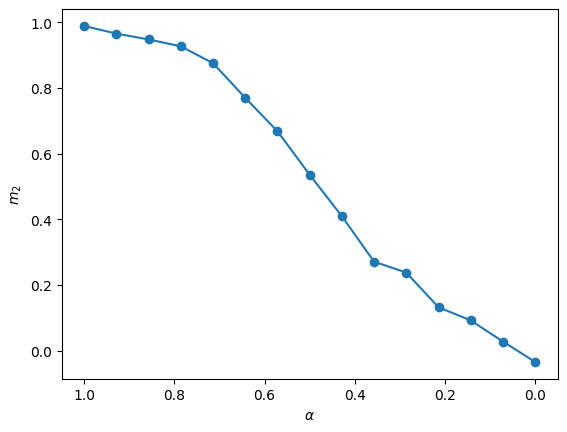

In [21]:
plt.plot(alphas, data, 'o-')
plt.gca().invert_xaxis()
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$m_2$');

We can see that for this small chain, the overlap to the $Z_2$ state (measured here through $m_2$) is reduced for small $\alpha$. This is because smaller $\alpha$ correspond to the state preparation of a state with weak final detuning which is unable to force atoms in the excited state, and thus the states tend to $|000...0\rangle$.

You can try to create other measurements for the $Z_3$, $Z_4$ states, and play with other pulse shapes in the state preparation/quantum simulation of the chain of atoms.

## Exercice 4.1

- Comment écriveriez-vous un paramètre d'ordre pour les états $Z_3$, $Z_4$, etc?
- Si vous changez $\Omega$, vous changez $R_b$. Qu'arrive-t'il lorsque l'on passe d'une phase $Z_2$ à une phase $Z_3$ (frontière entre vert et rose)

## Exercice 5:

- Qu'arrive-t'il si vous utilisez un réseau carré? Y-a-t'il des phases équivalentes à $Z_2$ et $Z_3$?
- Qu'arrive-t'il pour un réseau triangulaire (voir web)? Quel devrait être l'état fondamental (bitstring de plus basse énergie)? Y-a-t'il une transition de phase?
- Jouer sur Pulser Studio!